# EDA and Data cleaning

This document reports our strategy for preprocessing the data and preliminary findings from EDA. Below, we present a schematic diagram that summarizes these operations. In short, we start by performing a 80/20 train-test split. Then, we conduct explanatory data analysis including univarate analysis and pairwise feature analysis on the training set. Using the results of EDA, we identified missing values and impute (HAVEN"T FINISHED) the missing values for some features that significantly correlates with other features. We add a missing state for those features that have not gone through data imputation. Finally, we convert catgorical variables into boolean vectors by the one-hot encoding.

For implementation of missing value identifying and data imputing, please refer to ``main_module.py`` under the ``scripts`` folder. 

![diagram](figs/EDA_Clean_Diagram.png)

## Data cleaning

In [1]:
# import packages
import pandas as pd
import numpy as np
import scripts.main_module as md
from matplotlib import pyplot as plt

main module is loaded
c:\Users\rzhang98\source\repos\CIBMTR_post_hct_survival\scripts\main_module.py


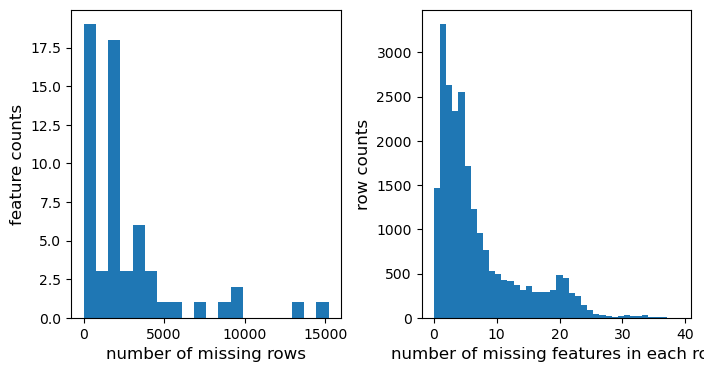

In [2]:
# Missing value analysis
hct_df = md.hct("data/train_set.csv")
df_cleaned = hct_df.clean(method="replace", params=\
                          [["Not done", "Not tested", "Other", "Missing disease status", "Non-resident of the U.S."], \
                           'missing'])

fig, ax = plt.subplots(figsize=(8,4), nrows = 1, ncols= 2)
plt.subplots_adjust(wspace=0.3)
ax[0].hist(df_cleaned[(df_cleaned == -1.0) | (df_cleaned == 'missing')].count(), bins = 20)
ax[0].set_ylabel("feature counts", fontsize=12)
ax[0].set_xlabel("number of missing rows", fontsize=12)

ax[1].hist(((df_cleaned == -1.0) | (df_cleaned == 'missing')).sum(axis = 1), bins = 40)
ax[1].set_ylabel("row counts", fontsize=12)
ax[1].set_xlabel("number of missing features in each row", fontsize=12)
plt.show()

In [3]:
# display one-hot encoded data matrix
df_converted = pd.get_dummies(df_cleaned)
df_converted.head()

,ID,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,...,donor_related_missing,melphalan_dose_MEL,"melphalan_dose_N/A, Mel not given",melphalan_dose_missing,cardiac_No,cardiac_Yes,cardiac_missing,pulm_moderate_No,pulm_moderate_Yes,pulm_moderate_missing
0,16466,1.0,4.0,4.0,3.0,-1.0,-1.0,4.0,1.0,1.0,...,False,False,True,False,True,False,False,True,False,False
1,4038,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,...,False,True,False,False,True,False,False,True,False,False
2,7006,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,...,False,False,True,False,True,False,False,False,True,False
3,9798,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,...,False,True,False,False,True,False,False,True,False,False
4,14496,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,...,False,False,True,False,True,False,False,True,False,False


In [4]:
%cd scripts/

c:\Users\rzhang98\source\repos\CIBMTR_post_hct_survival\scripts


## Plot Selected Features by Survival Outcomes

In this notebook we plot survival outcome (event/censored) and survival time for selected features. We examine:
- `age_at_hct`
- `comorbidity_score`
- `karnofsky_score`
- `hla_match_drb1_high`
- `hla_high_res_10`
- `race_group`

The first four features were identified as imortant via experiments with lasso regression. The feature `hla_high_res_10` is an overall measure of genetic compatibility of donor vs. recipient. Since one HLA match feature was identified as important, it seems reasonable to consider overall HLA match. Finall, race is relevant to our metric (risk score, stratified by race). The feature `hla_match_drb1_low`, which was also flagged as important, is not included. That feature is a less-sensitive measure of the same allele match as `hla_match_drb1_low`.

#### Load Data

In [5]:
# Import libraries and modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [6]:
df = pd.read_csv("../data/train_set.csv")
df['efs'] = df['efs'].replace({0:"Censored", 1:"Event"})

In [7]:
print("The training set has {} rows and {} columns".format(df.shape[0], df.shape[1]))

The training set has 23040 rows and 60 columns


#### Define Helper Functions to Plot Features

In [8]:
# Function that takes the name of 
# and produces a histogram of the number of 
# cases for each value of the feature, 
# broken down by efs (Event/Censored).

def hist_by_efs(feat_name, df=df, tick_angle = 0, figsize=(6, 3), discrete=True, bins='auto'):
    fig, ax = plt.subplots(figsize=figsize)
    sns.histplot(df, x = feat_name, hue='efs', discrete=discrete, multiple='stack', bins=bins,
                hue_order=['Censored', 'Event'])
    plt.xlabel(feat_name)
    plt.ylabel("Number of cases")
    plt.title("Number of cases by {}".format(feat_name))
    ax.tick_params(axis='x', rotation=tick_angle)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [9]:
def scatter_by_efs_discrete(feat_name, df=df, tick_angle=0, figsize=(12, 3)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.stripplot(data = df, x = feat_name, y = 'efs_time', hue='efs', jitter=0.3, alpha=0.3, )
    plt.tick_params(axis='x', rotation=tick_angle)
    plt.title("Scatter plot of {} vs. survival time".format(feat_name))
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [10]:
def scatter_by_efs_continuous(feat_name, df=df, tick_angle=0, figsize=(6, 3)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(data = df, x = feat_name, y = 'efs_time', hue='efs', alpha=0.3)
    plt.tick_params(axis='x', rotation=tick_angle)
    plt.title("Scatter plot of {} vs. survival time".format(feat_name))
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

#### Plots for Selected Features

##### age_at_hct

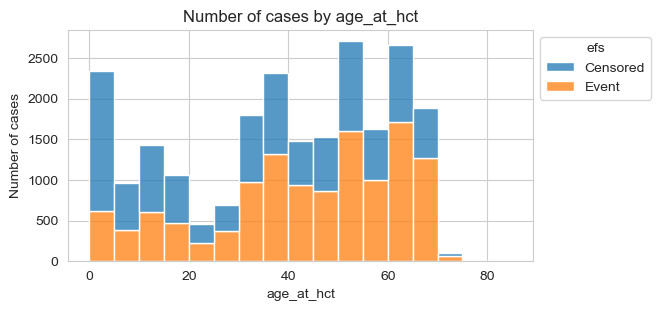

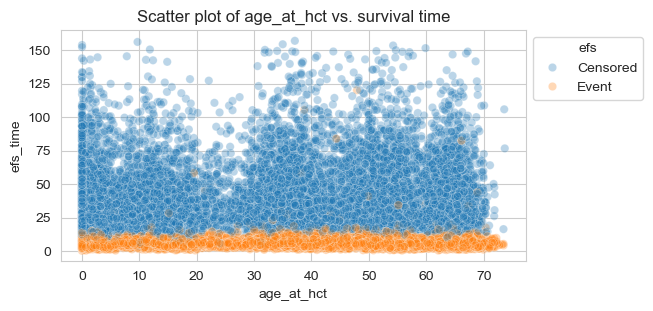

In [11]:
hist_by_efs('age_at_hct', discrete=False, bins=range(0, 90, 5))
scatter_by_efs_continuous('age_at_hct')

##### comorbidity_score

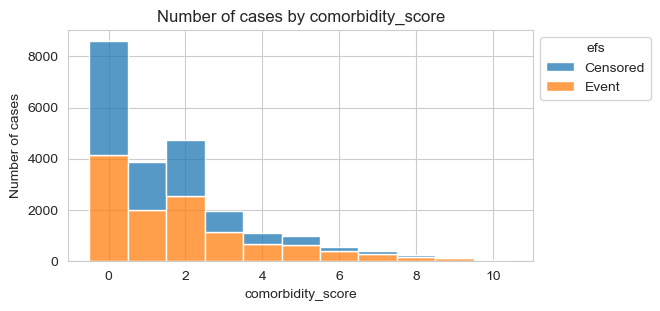

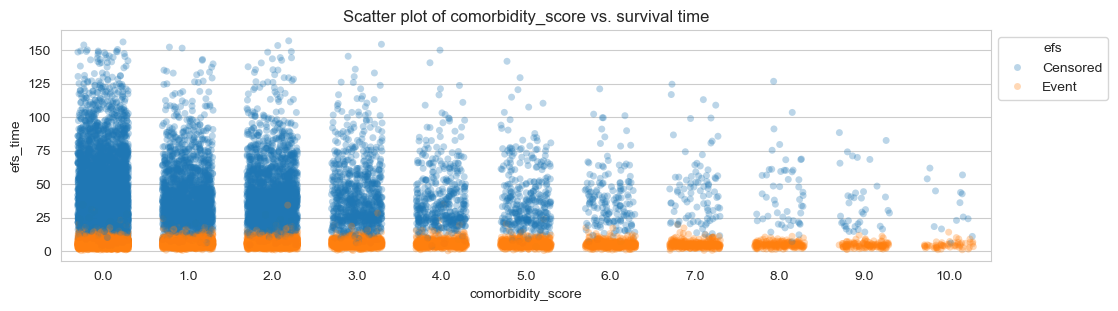

In [12]:
hist_by_efs('comorbidity_score')
scatter_by_efs_discrete('comorbidity_score')

##### karnofsky_score

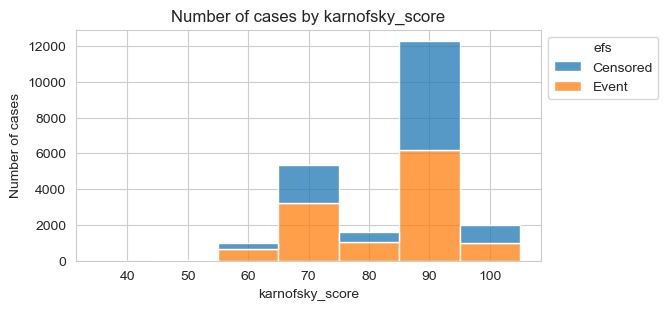

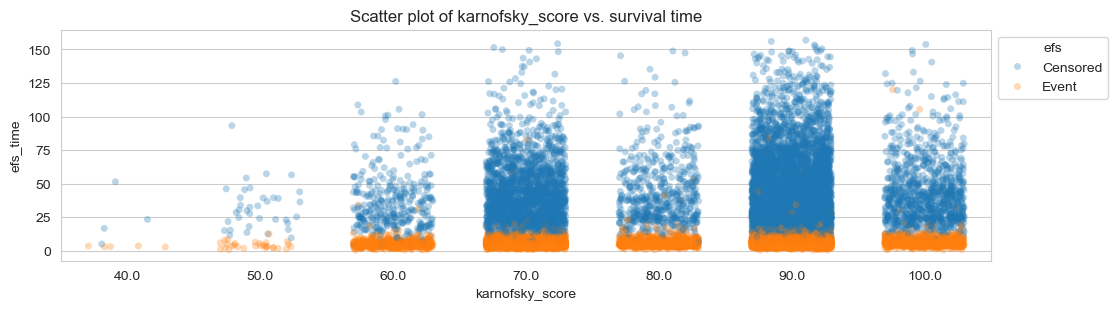

In [13]:
hist_by_efs('karnofsky_score', discrete=False, bins=range(35, 115, 10))
scatter_by_efs_discrete('karnofsky_score')

##### hla_match_drb1_high

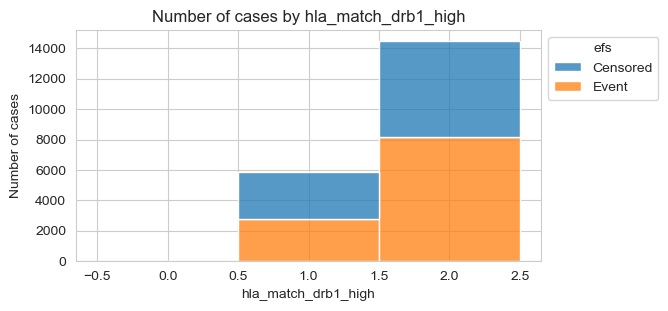

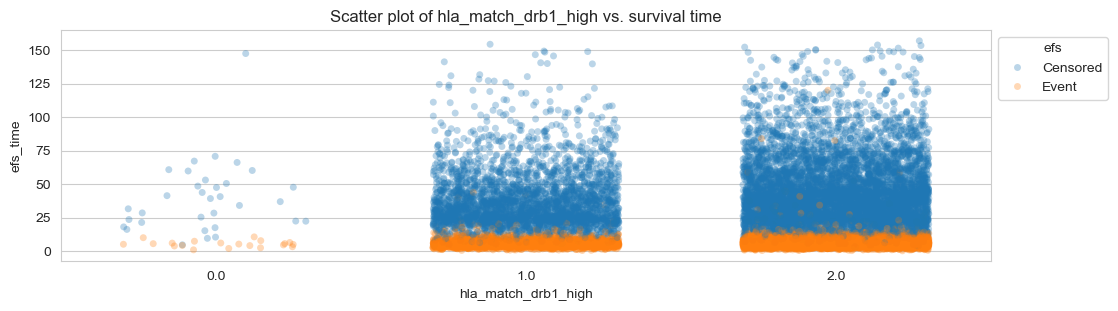

In [14]:
hist_by_efs('hla_match_drb1_high', discrete=True)
scatter_by_efs_discrete('hla_match_drb1_high')

##### hla_high_res_10

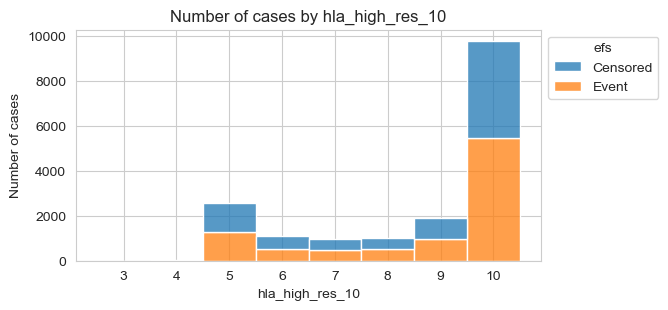

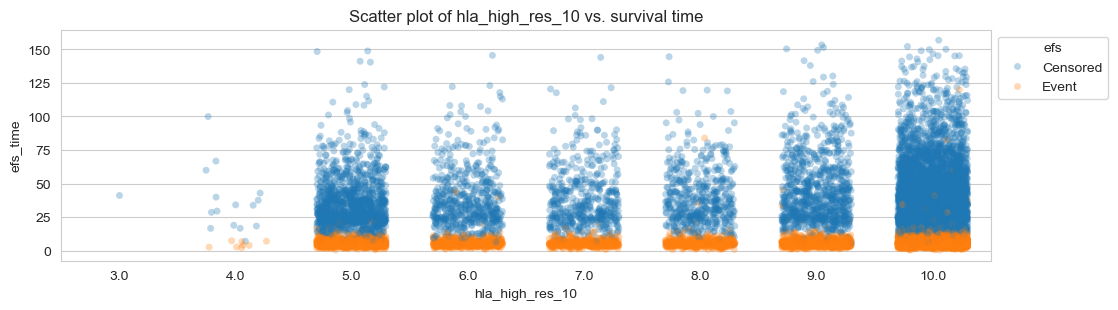

In [15]:
hist_by_efs('hla_high_res_10', discrete=True)
scatter_by_efs_discrete('hla_high_res_10')

##### race_group

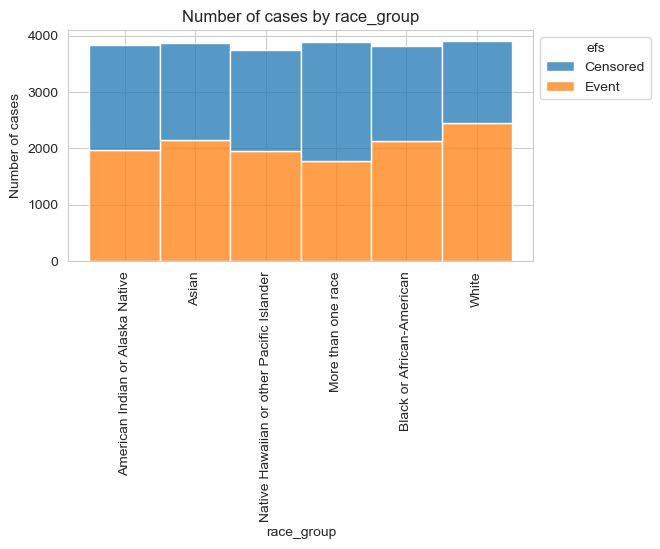

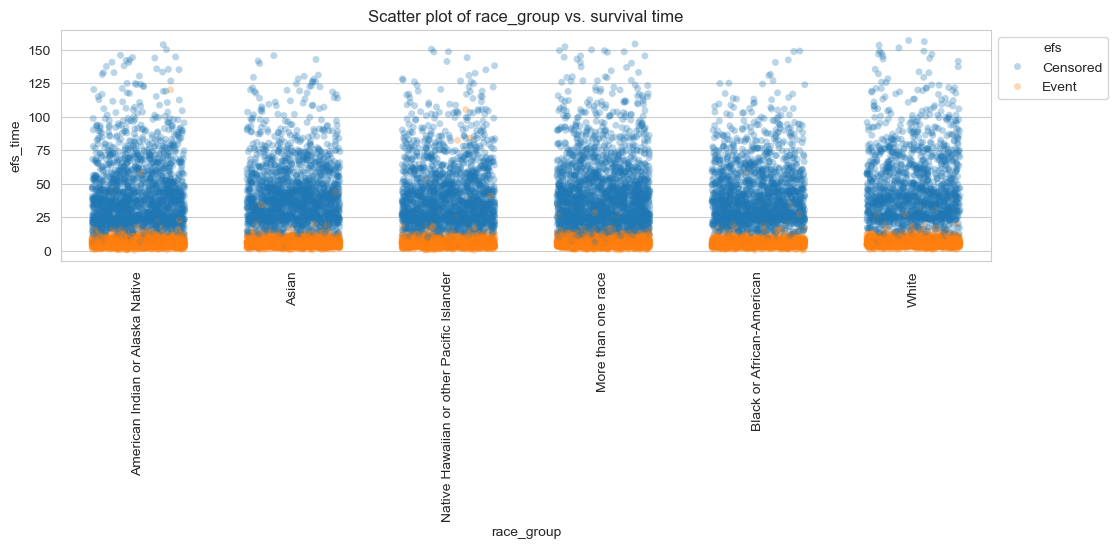

In [16]:
hist_by_efs('race_group', tick_angle=90)
scatter_by_efs_discrete('race_group', tick_angle=90)

#### Main Take-aways

- Based on these plots, it appears that younger patients have better survival outcomes. They are less likely to be recoded as `Event`, and tend to have higher survival times. Pediatric patients especially do well.
- Patients with higher comorbidity scores have worse outcomes, as expected. They are much more likely to be coded as `Event` and have lower survival times.
- Surprisingly, the plots do not show obvious trends based on HLA match or karnofsky score (a measure of day-to-day functioning). These may more informative in combination with other features, of the trends may be too subtle to be obvious on a plot.

## Representative Correlation Analysis
In this section we display some plots that are most significant in the pairwise feature analysis.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import scipy.stats as stats

from sklearn.ensemble import RandomForestClassifier

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

In [ ]:
path_train = '../data/train_set.csv'

In [ ]:
data = pd.read_csv(path_train)
data.head()
data.columns
X = data.iloc[:,1:-2]
y = data.iloc[:,-2:]

<function matplotlib.pyplot.show(close=None, block=None)>

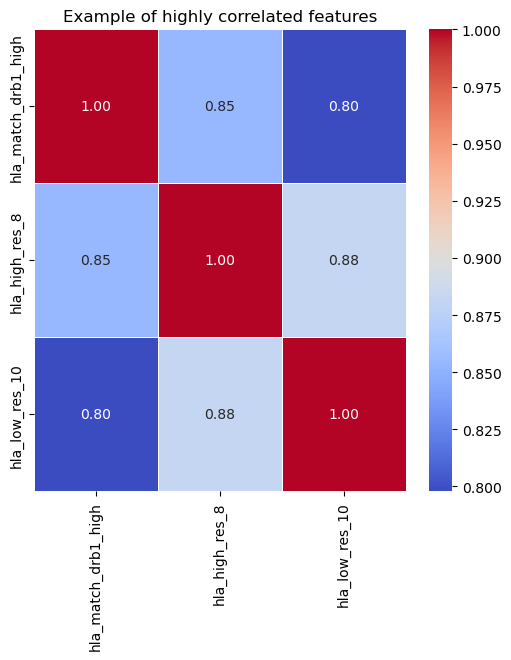

In [ ]:
# Correlation matrix example

example_numerical  = X[['hla_match_drb1_high','hla_high_res_8','hla_low_res_10']]
example_corr= example_numerical.corr(method='spearman')
plt.figure(figsize = (6,6))
sns.heatmap(example_corr,annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Example of highly correlated features')
plt.show

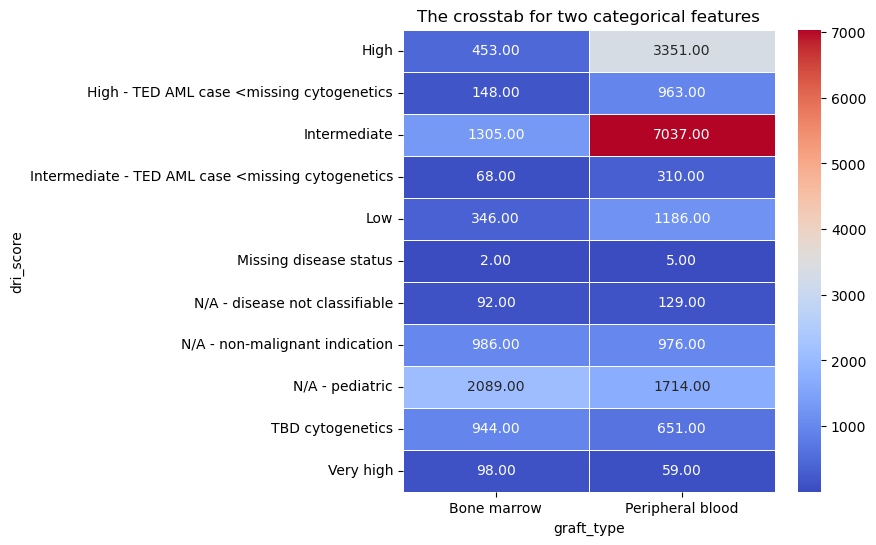

In [ ]:
# A crosstab of two categorical variables with interesting frequency pattern (intermediate/Peripheral blood)

plt.figure(figsize=(6, 6))

ctab = pd.crosstab(X['dri_score'], X['graft_type'])
sns.heatmap(ctab,annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('The crosstab for two categorical features')
plt.show()



In [18]:
%cd -

c:\Users\rzhang98\source\repos\CIBMTR_post_hct_survival
